In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import scipy as sp
import seaborn as sns
#from PIL import Image

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() is not None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split is not None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [4]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [5]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    return ax

# Setting Up the Data

In [6]:
dfhw = pd.read_csv("01_heights_weights_genders.csv")

In [7]:
dfhw.shape

(10000, 3)

In [8]:
dfhw.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [9]:
df = dfhw.sample(500, replace = False)
np.sum(df.Gender == "Male")

239

In [10]:
itrain, itest = train_test_split(range(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask[:10]

array([False, False,  True, False,  True,  True,  True, False, False,
        True])

# Logistic Regression

using mask
BEST {'C': 100} 0.9233333333333333 {'mean_fit_time': array([0.00079007, 0.00098886, 0.00020456, 0.00079589, 0.00079207,
       0.00078645, 0.00100951, 0.00099196]), 'std_fit_time': array([3.95328011e-04, 6.18087916e-04, 4.09126282e-04, 4.00377092e-04,
       7.43059406e-04, 3.93604671e-04, 1.70394408e-05, 6.05975959e-04]), 'mean_score_time': array([0.        , 0.        , 0.00080543, 0.00020247, 0.00060368,
       0.00019956, 0.        , 0.        ]), 'std_score_time': array([0.        , 0.        , 0.00040307, 0.00040493, 0.00049317,
       0.00039911, 0.        , 0.        ]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}, {'C': 10000}], 'split0_test_score': array([0.91803279, 0.91803279, 0.91803279, 0.91803279, 0.91803279,
    

c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\91998\appdata\local\programs\python\python37\lib\si

(<matplotlib.axes._subplots.AxesSubplot at 0x2171f4e9da0>,
 array([[56.66584006, 56.87475845, 57.08367685, ..., 76.93092448,
         77.13984287, 77.34876127],
        [56.66584006, 56.87475845, 57.08367685, ..., 76.93092448,
         77.13984287, 77.34876127],
        [56.66584006, 56.87475845, 57.08367685, ..., 76.93092448,
         77.13984287, 77.34876127],
        ...,
        [56.66584006, 56.87475845, 57.08367685, ..., 76.93092448,
         77.13984287, 77.34876127],
        [56.66584006, 56.87475845, 57.08367685, ..., 76.93092448,
         77.13984287, 77.34876127],
        [56.66584006, 56.87475845, 57.08367685, ..., 76.93092448,
         77.13984287, 77.34876127]]),
 array([[ 92.29145025,  92.29145025,  92.29145025, ...,  92.29145025,
          92.29145025,  92.29145025],
        [ 93.9320323 ,  93.9320323 ,  93.9320323 , ...,  93.9320323 ,
          93.9320323 ,  93.9320323 ],
        [ 95.57261435,  95.57261435,  95.57261435, ...,  95.57261435,
          95.57261435,  95.5

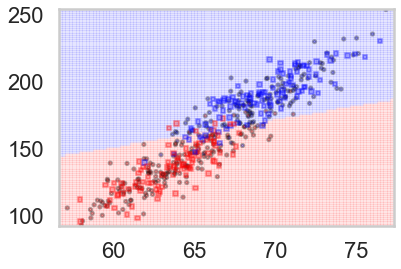

In [12]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog)

In [13]:
clflog.predict(Xtest)

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0])

In [14]:
clflog.predict_proba(Xtest)

array([[2.75517167e-03, 9.97244828e-01],
       [9.99888888e-01, 1.11112461e-04],
       [6.93692781e-01, 3.06307219e-01],
       [8.76294237e-03, 9.91237058e-01],
       [4.91624504e-01, 5.08375496e-01],
       [7.14145871e-02, 9.28585413e-01],
       [9.96928498e-01, 3.07150157e-03],
       [3.09282757e-02, 9.69071724e-01],
       [9.74753517e-01, 2.52464831e-02],
       [1.82904085e-02, 9.81709591e-01],
       [8.62259948e-01, 1.37740052e-01],
       [9.86612253e-01, 1.33877474e-02],
       [9.98943584e-01, 1.05641562e-03],
       [9.56461921e-01, 4.35380787e-02],
       [8.31010124e-01, 1.68989876e-01],
       [4.30119597e-02, 9.56988040e-01],
       [9.96191833e-01, 3.80816694e-03],
       [9.34429103e-04, 9.99065571e-01],
       [2.41730080e-02, 9.75826992e-01],
       [7.90359123e-02, 9.20964088e-01],
       [9.74136680e-01, 2.58633201e-02],
       [9.48949354e-01, 5.10506461e-02],
       [9.94418056e-01, 5.58194429e-03],
       [4.62960757e-02, 9.53703924e-01],
       [1.900228

In [15]:
clflog.predict_proba(Xtest)[:, 1]

array([9.97244828e-01, 1.11112461e-04, 3.06307219e-01, 9.91237058e-01,
       5.08375496e-01, 9.28585413e-01, 3.07150157e-03, 9.69071724e-01,
       2.52464831e-02, 9.81709591e-01, 1.37740052e-01, 1.33877474e-02,
       1.05641562e-03, 4.35380787e-02, 1.68989876e-01, 9.56988040e-01,
       3.80816694e-03, 9.99065571e-01, 9.75826992e-01, 9.20964088e-01,
       2.58633201e-02, 5.10506461e-02, 5.58194429e-03, 9.53703924e-01,
       8.09977110e-01, 9.71327002e-01, 2.87322789e-02, 6.47933941e-03,
       9.19739443e-01, 1.25739536e-02, 1.16110061e-01, 9.98736880e-01,
       1.80233861e-03, 6.89124333e-01, 4.34375428e-01, 9.97843932e-01,
       8.77875144e-01, 9.77425789e-01, 2.54119321e-03, 9.98446105e-01,
       8.01890918e-02, 2.75848275e-03, 9.70771886e-01, 8.01103115e-03,
       8.69709172e-01, 6.34752175e-03, 5.51618881e-01, 4.27990622e-03,
       9.92936812e-01, 9.12306185e-01, 9.42876713e-02, 4.53684756e-01,
       7.13289614e-01, 1.32552826e-02, 9.94032566e-01, 9.97237409e-01,
      

(array([74.,  7.,  4.,  7.,  5.,  7.,  5.,  7.,  5., 79.]),
 array([1.11112461e-02, 1.00046214e+01, 1.99981315e+01, 2.99916417e+01,
        3.99851518e+01, 4.99786620e+01, 5.99721721e+01, 6.99656823e+01,
        7.99591924e+01, 8.99527025e+01, 9.99462127e+01]),
 <a list of 10 Patch objects>)

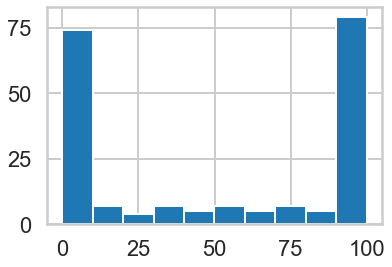

In [16]:
plt.hist(clflog.predict_proba(Xtest)[:, 1]*100)

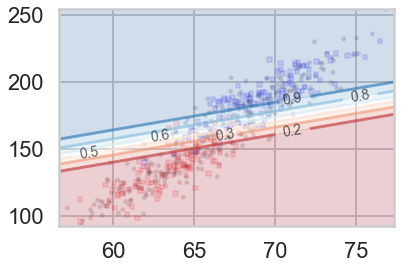

In [17]:
plt.figure()
ax = plt.gca()

points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh = False, alpha = 0.001)
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog)

In [18]:
clflog.score(Xtest, ytest)

0.9

# SVM

using mask
BEST {'C': 0.1} 0.92 {'mean_fit_time': array([0.00099726, 0.00079794, 0.00139651, 0.00438781, 0.02974029,
       0.13841367, 0.35665965]), 'std_fit_time': array([2.33601546e-07, 3.98969665e-04, 4.88830854e-04, 1.84961721e-03,
       1.80818970e-02, 4.34872904e-02, 2.48413791e-01]), 'mean_score_time': array([0.        , 0.        , 0.        , 0.        , 0.00059209,
       0.00019932, 0.        ]), 'std_score_time': array([0.        , 0.        , 0.        , 0.        , 0.00048349,
       0.00039864, 0.        ]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.91803279, 0.91803279, 0.91803279, 0.91803279, 0.91803279,
       0.91803279, 0.91803279]), 'split1_test_score': array([0.90163934, 0.90163934, 0.91803279, 0

c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(<matplotlib.axes._subplots.AxesSubplot at 0x217218fbe80>,
 array([[56.66584006, 56.87475845, 57.08367685, ..., 76.93092448,
         77.13984287, 77.34876127],
        [56.66584006, 56.87475845, 57.08367685, ..., 76.93092448,
         77.13984287, 77.34876127],
        [56.66584006, 56.87475845, 57.08367685, ..., 76.93092448,
         77.13984287, 77.34876127],
        ...,
        [56.66584006, 56.87475845, 57.08367685, ..., 76.93092448,
         77.13984287, 77.34876127],
        [56.66584006, 56.87475845, 57.08367685, ..., 76.93092448,
         77.13984287, 77.34876127],
        [56.66584006, 56.87475845, 57.08367685, ..., 76.93092448,
         77.13984287, 77.34876127]]),
 array([[ 92.29145025,  92.29145025,  92.29145025, ...,  92.29145025,
          92.29145025,  92.29145025],
        [ 93.9320323 ,  93.9320323 ,  93.9320323 , ...,  93.9320323 ,
          93.9320323 ,  93.9320323 ],
        [ 95.57261435,  95.57261435,  95.57261435, ...,  95.57261435,
          95.57261435,  95.5

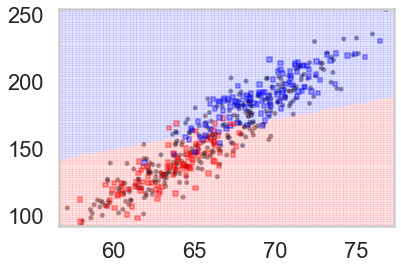

In [21]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm)

In [23]:
clfsvm.decision_function(Xtest)

array([ 4.10136512e+00, -6.45690038e+00, -5.43042416e-01,  3.32304469e+00,
        5.84633948e-02,  1.83734749e+00, -4.02683852e+00,  2.46563208e+00,
       -2.55908865e+00,  2.81385954e+00, -1.29593679e+00, -2.94868853e+00,
       -4.87578587e+00, -2.17520679e+00, -1.12623982e+00,  2.25153733e+00,
       -3.92245723e+00,  4.93466271e+00,  2.66708086e+00,  1.67546518e+00,
       -2.55100710e+00, -1.98934905e+00, -3.61486724e+00,  2.11329446e+00,
        1.10335062e+00,  2.57798867e+00, -2.47514550e+00, -3.52390978e+00,
        1.69061610e+00, -3.13102991e+00, -1.38334417e+00,  4.75368016e+00,
       -4.46822416e+00,  6.39568953e-01, -1.63305918e-01,  4.32388302e+00,
        1.39579193e+00,  2.71270672e+00, -4.21362054e+00,  4.52932683e+00,
       -1.64181338e+00, -4.10406617e+00,  2.45196951e+00, -3.41757145e+00,
        1.33390940e+00, -3.49194640e+00,  1.61714700e-01, -3.81537043e+00,
        3.58193613e+00,  1.67295641e+00, -1.56874265e+00, -6.38171509e-02,
        6.22513362e-01, -

(array([ 4., 11., 24., 29., 20., 22., 22., 38., 14., 16.]),
 array([-6.45690038, -5.27049337, -4.08408636, -2.89767935, -1.71127234,
        -0.52486533,  0.66154168,  1.84794868,  3.03435569,  4.2207627 ,
         5.40716971]),
 <a list of 10 Patch objects>)

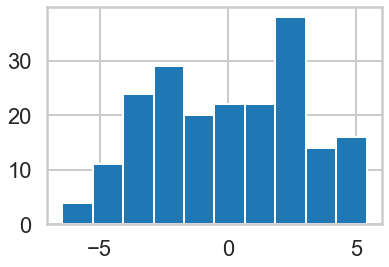

In [24]:
plt.hist(clfsvm.decision_function(Xtest))

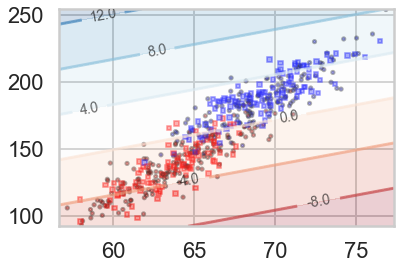

In [25]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, mesh=False)
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, prob=False)

In [27]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

ValueError: Expected 2D array, got 1D array instead:
array=[56.66584006 92.29145025].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

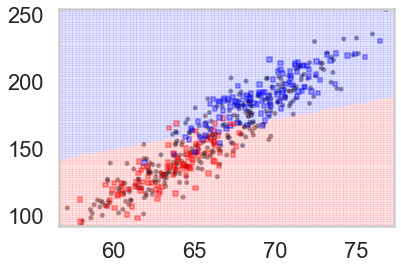

In [29]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm, ax)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

# Confusion Matrix

In [30]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[85,  8],
       [12, 95]], dtype=int64)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(ytest, clflog.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89        93
           1       0.92      0.89      0.90       107

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



The Cancer Doctor

In [32]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [33]:
confusion_matrix(ytest, t_repredict(clflog, 0.1, Xtest))

array([[ 72,  21],
       [  2, 105]], dtype=int64)

# ROC Curve

In [34]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

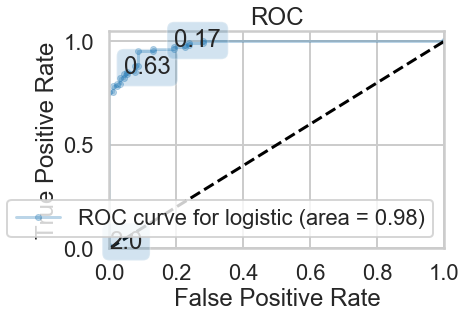

In [35]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clflog, ytest, Xtest, labe=10)

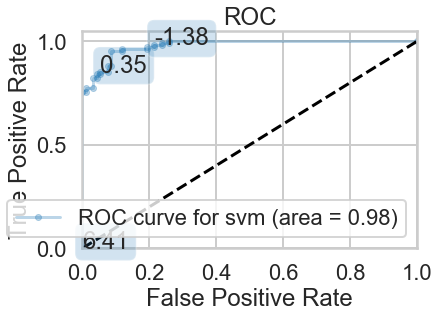

In [36]:
make_roc("svm", clfsvm, ytest, Xtest, labe=10, proba=False)